In [ ]:
"""
Baseline predictive maintenance model.
Compares Random Forest, XGBoost, and LightGBM for failure prediction.
"""
#General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

# Machine learning imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import os
from pathlib import Path

# directorio del proyecto
project_root = Path(__file__).parent.parent if '__file__' in locals() else Path.cwd().parent
os.chdir(project_root)

print(f"Working directory: {os.getcwd()}")
print(f"Data files exist: {os.path.exists('data/raw/PdM_telemetry.csv')}")

# Install boosting libraries if needed
try:
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    print("All packages available from requirements.txt")
except ImportError as e:
    print(f"Import error: {e}")

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
RANDOM_STATE = 42
PREDICTION_WINDOW_DAYS = 3

print(f"Notebook started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Working directory: /Users/brayancuevas/Documents/Mis_Proyectos_ML/predictive-maintenance-mlop_waltmart
Data files exist: True
✓ Boosting libraries available
Notebook started: 2025-05-30 22:42:52


In [ ]:
def load_data(data_path='data/raw'):
    """Load telemetry and failures data with basic validation."""

    # Load datasets
    telemetry_file = os.path.join(data_path, 'PdM_telemetry.csv')
    failures_file = os.path.join(data_path, 'PdM_failures.csv')
    try:
        telemetry = pd.read_csv(telemetry_file)
        failures = pd.read_csv(failures_file)

        # Convert datetime
        telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
        failures['datetime'] = pd.to_datetime(failures['datetime'])

        print(f"Telemetry: {telemetry.shape}")
        print(f"Failures: {failures.shape}")
        print(f"Date range: {telemetry['datetime'].min().date()} to {telemetry['datetime'].max().date()}")
        print(f"Machines: {telemetry['machineID'].nunique()}")
        print(f"Total failures: {len(failures)}")

        return telemetry, failures

    except FileNotFoundError as e:
        print(f"Error: Could not find required files in {data_path}/")
        print("Required files: PdM_telemetry.csv, PdM_failures.csv")
        return None, None

# Load data
telemetry, failures = load_data()

Telemetry: (876100, 6)
Failures: (761, 3)
Date range: 2015-01-01 to 2016-01-01
Machines: 100
Total failures: 761


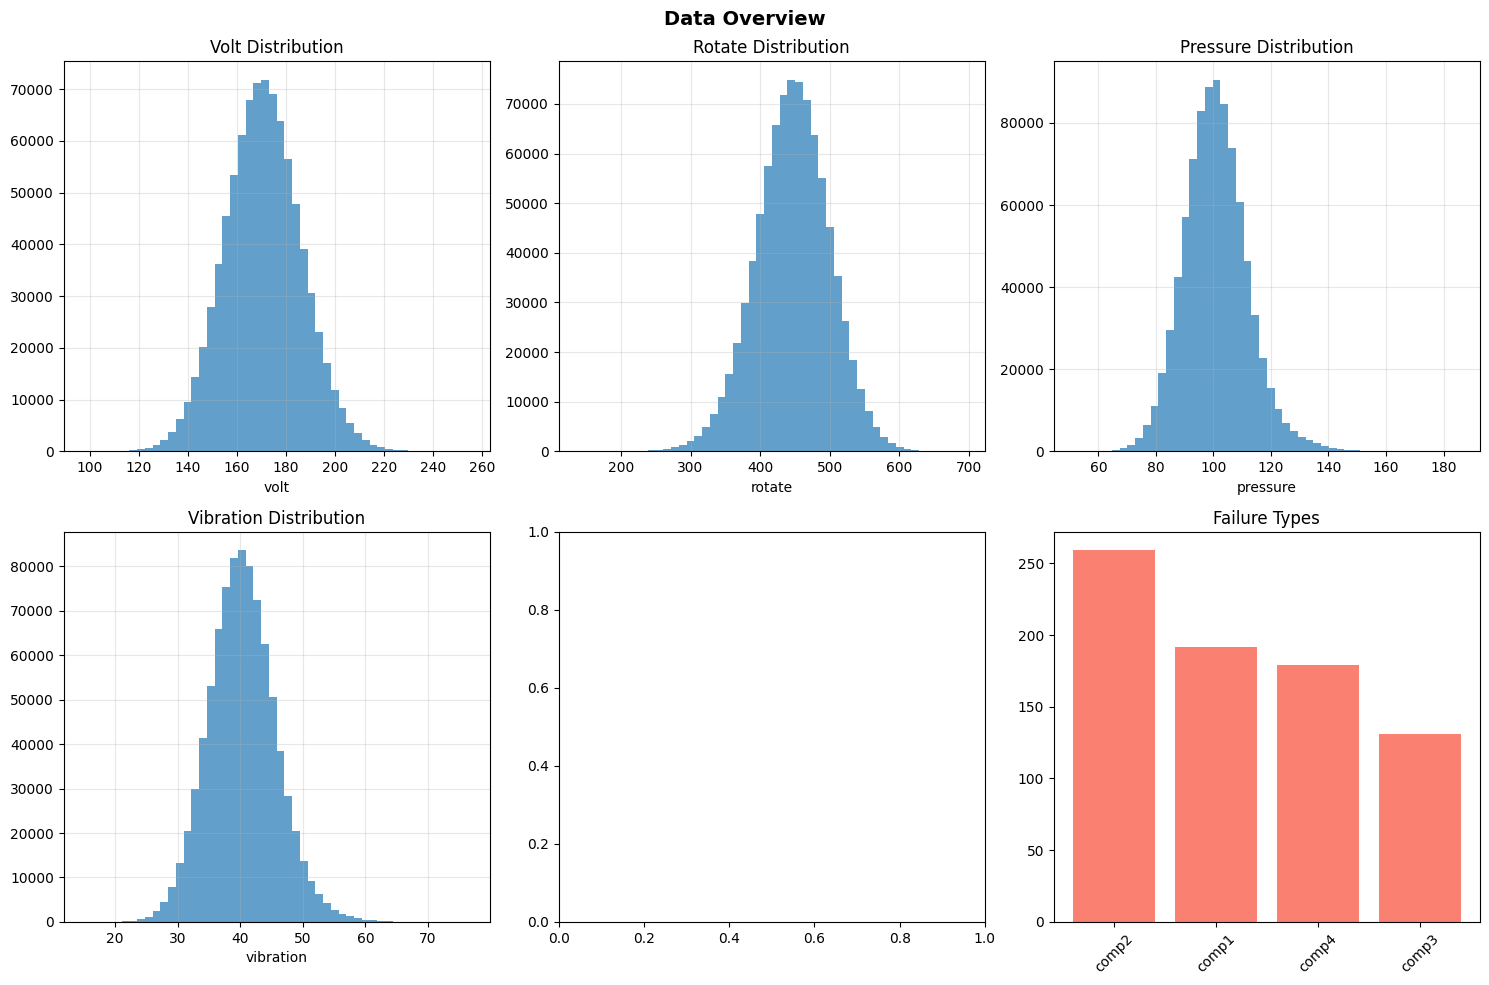

No missing values found


In [3]:
def visualize_data(telemetry_df, failures_df):
    """Create basic visualizations for data understanding."""

    # Setup plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Data Overview', fontsize=14, fontweight='bold')

    # Sensor distributions
    sensors = ['volt', 'rotate', 'pressure', 'vibration']
    for i, sensor in enumerate(sensors):
        row, col = divmod(i, 3)
        ax = axes[row, col]

        telemetry_df[sensor].hist(bins=50, alpha=0.7, ax=ax)
        ax.set_title(f'{sensor.title()} Distribution')
        ax.set_xlabel(sensor)
        ax.grid(True, alpha=0.3)

    # Failure types
    failure_counts = failures_df['failure'].value_counts()
    axes[1, 2].bar(failure_counts.index, failure_counts.values, color='salmon')
    axes[1, 2].set_title('Failure Types')
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Check missing values
    missing = telemetry_df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values found")
    else:
        print(f"Missing values detected:")
        print(missing[missing > 0])

# Generate visualizations
if telemetry is not None:
    visualize_data(telemetry, failures)

In [4]:
def create_features(df, sensors=['volt', 'rotate', 'pressure', 'vibration']):
    """Create rolling window features for temporal patterns."""

    print("Creating rolling features...")

    # Sort by machine and time
    df_processed = df.copy()
    df_processed = df_processed.sort_values(['machineID', 'datetime'])

    # Create rolling features (3h and 24h windows)
    for sensor in sensors:
        # 3-hour rolling
        df_processed[f'{sensor}_3h_mean'] = (
            df_processed.groupby('machineID')[sensor]
            .rolling(3, min_periods=1).mean()
            .reset_index(0, drop=True)
        )
        df_processed[f'{sensor}_3h_std'] = (
            df_processed.groupby('machineID')[sensor]
            .rolling(3, min_periods=1).std()
            .reset_index(0, drop=True)
        )

        # 24-hour rolling mean
        df_processed[f'{sensor}_24h_mean'] = (
            df_processed.groupby('machineID')[sensor]
            .rolling(24, min_periods=1).mean()
            .reset_index(0, drop=True)
        )

    # Handle missing values
    df_processed = df_processed.fillna(method='ffill').fillna(0)

    print(f"Created features: {df_processed.shape[1]} total columns")
    return df_processed

# Apply feature engineering
if telemetry is not None:
    telemetry_with_features = create_features(telemetry)

Creating rolling features...
Created features: 18 total columns


In [5]:
def create_target(telemetry_df, failures_df, window_days=PREDICTION_WINDOW_DAYS):
    """Create binary target for failure prediction."""

    print(f"Creating target variable (predict failures {window_days} days ahead)...")

    df = telemetry_df.copy()
    df['target'] = 0

    # Mark failure windows
    for _, failure in failures_df.iterrows():
        machine_id = failure['machineID']
        failure_time = failure['datetime']

        # Mark records in prediction window
        mask = (
            (df['machineID'] == machine_id) &
            (df['datetime'] >= failure_time - pd.Timedelta(days=window_days)) &
            (df['datetime'] < failure_time)
        )

        df.loc[mask, 'target'] = 1

    # Report class distribution
    failure_rate = df['target'].mean()
    print(f"Failure rate: {failure_rate*100:.2f}%")
    print(f"Positive samples: {df['target'].sum():,}")
    print(f"Negative samples: {(df['target'] == 0).sum():,}")

    return df

# Create target
if 'telemetry_with_features' in locals():
    dataset = create_target(telemetry_with_features, failures)

Creating target variable (predict failures 3 days ahead)...
Failure rate: 5.79%
Positive samples: 50,736
Negative samples: 825,364


In [6]:
def prepare_data(df):
    """Prepare features and create temporal train/test split."""

    # Use all engineered features (no feature selection for baseline)
    feature_columns = [col for col in df.columns
                      if col not in ['datetime', 'machineID', 'target']]

    X = df[feature_columns]
    y = df['target']

    print(f"Features used: {len(feature_columns)}")
    print(f"Total samples: {len(X):,}")

    # Temporal split (80/20)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training: {len(X_train):,} samples ({y_train.mean()*100:.1f}% failures)")
    print(f"Testing: {len(X_test):,} samples ({y_test.mean()*100:.1f}% failures)")

    return X_train, X_test, y_train, y_test, feature_columns

# Prepare data
if 'dataset' in locals():
    X_train, X_test, y_train, y_test, feature_names = prepare_data(dataset)

Features used: 16
Total samples: 876,100
Training: 700,880 samples (5.6% failures)
Testing: 175,220 samples (6.7% failures)


In [7]:
def compare_models(X_train, y_train, X_test, y_test):
    """Train and compare multiple models."""

    print("Training models...")

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            max_depth=8,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            verbosity=-1
        )
    }

    # Train and evaluate
    results = {}

    for name, model in models.items():
        print(f"\n{name}:")

        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'auc': auc,
            'probabilities': y_pred_proba
        }

        print(f"  AUC: {auc:.4f}")

    return results

# Compare models
if 'X_train' in locals():
    model_results = compare_models(X_train, y_train, X_test, y_test)

    # Find best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['auc'])
    best_auc = model_results[best_model_name]['auc']

    print(f"\nBest Model: {best_model_name}")
    print(f"Best AUC: {best_auc:.4f}")

Training models...

Random Forest:
  AUC: 0.7943

XGBoost:
  AUC: 0.7750

LightGBM:
  AUC: 0.7915

Best Model: Random Forest
Best AUC: 0.7943



📊 Detailed Results - Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    163427
           1       0.28      0.65      0.39     11793

    accuracy                           0.87    175220
   macro avg       0.63      0.77      0.66    175220
weighted avg       0.93      0.87      0.89    175220


Confusion Matrix:
True Negatives: 143,966
False Positives: 19,461
False Negatives: 4,127
True Positives: 7,666

Business Metrics:
Precision: 0.283 (28.3% of predictions correct)
Recall: 0.650 (65.0% of failures caught)
False Alarm Rate: 11.9%


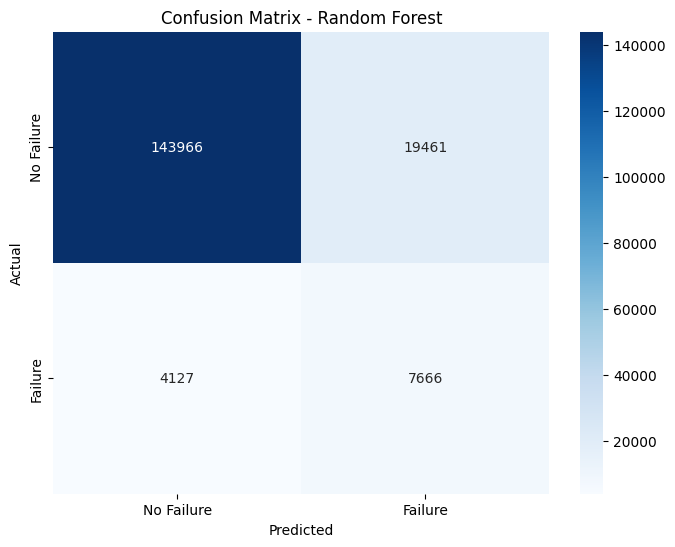

In [8]:
def evaluate_best_model(results, best_name, y_test):
    """Detailed evaluation of the best performing model."""

    best_model = results[best_name]['model']
    y_pred = best_model.predict(X_test)
    y_pred_proba = results[best_name]['probabilities']

    print(f"\n📊 Detailed Results - {best_name}")
    print("="*40)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\nConfusion Matrix:")
    print(f"True Negatives: {tn:,}")
    print(f"False Positives: {fp:,}")
    print(f"False Negatives: {fn:,}")
    print(f"True Positives: {tp:,}")

    # Business metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\nBusiness Metrics:")
    print(f"Precision: {precision:.3f} ({precision*100:.1f}% of predictions correct)")
    print(f"Recall: {recall:.3f} ({recall*100:.1f}% of failures caught)")
    print(f"False Alarm Rate: {fp/(fp+tn)*100:.1f}%")

    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Failure', 'Failure'],
                yticklabels=['No Failure', 'Failure'])
    plt.title(f'Confusion Matrix - {best_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return best_model

# Evaluate best model
if 'model_results' in locals():
    best_model = evaluate_best_model(model_results, best_model_name, y_test)

In [9]:
def save_model(model, model_name, features, auc_score):
    """Save the trained model with metadata."""

    # Create models directory
    os.makedirs('models', exist_ok=True)

    # Model package
    model_package = {
        'model': model,
        'model_name': model_name,
        'features': features,
        'auc_score': auc_score,
        'prediction_window_days': PREDICTION_WINDOW_DAYS,
        'training_date': datetime.now().isoformat()
    }

    # Save model
    model_path = 'models/baseline_model.joblib'
    joblib.dump(model_package, model_path)

    print(f"Model saved: {model_path}")
    print(f"Model: {model_name}")
    print(f"AUC: {auc_score:.4f}")
    print(f"Features: {len(features)}")

    return model_path

# Save best model
if 'best_model' in locals():
    model_path = save_model(best_model, best_model_name, feature_names, best_auc)

Model saved: models/baseline_model.joblib
Model: Random Forest
AUC: 0.7943
Features: 16


In [10]:
def create_prediction_function():
    """Create and test simple prediction function."""

    def predict_failure(volt, rotate, pressure, vibration):
        """Predict failure risk for given sensor readings."""

        try:
            # Load model
            model_data = joblib.load('models/baseline_model.joblib')
            model = model_data['model']
            features = model_data['features']

            # Create input with basic sensors
            input_data = pd.DataFrame({
                'volt': [volt],
                'rotate': [rotate],
                'pressure': [pressure],
                'vibration': [vibration]
            })

            # Add rolling features (simplified for demo)
            sensors = ['volt', 'rotate', 'pressure', 'vibration']
            for sensor in sensors:
                input_data[f'{sensor}_3h_mean'] = input_data[sensor]
                input_data[f'{sensor}_3h_std'] = input_data[sensor] * 0.02
                input_data[f'{sensor}_24h_mean'] = input_data[sensor] * 0.98

            # Ensure all features present
            for feature in features:
                if feature not in input_data.columns:
                    input_data[feature] = 0.0

            # Predict
            prob = model.predict_proba(input_data[features])[0, 1]
            risk = 'HIGH' if prob > 0.5 else 'MEDIUM' if prob > 0.2 else 'LOW'

            return {
                'probability': prob,
                'risk_level': risk,
                'model': model_data['model_name']
            }

        except Exception as e:
            return {'error': str(e)}

    # Test prediction function
    print("🧪 Testing prediction function:")

    test_cases = [
        {'volt': 160, 'rotate': 440, 'pressure': 95, 'vibration': 35},
        {'volt': 180, 'rotate': 480, 'pressure': 110, 'vibration': 50}
    ]

    for i, case in enumerate(test_cases, 1):
        result = predict_failure(**case)
        print(f"\nTest {i}: {case}")
        if 'error' not in result:
            print(f"  Probability: {result['probability']:.3f}")
            print(f"  Risk: {result['risk_level']}")
        else:
            print(f"  Error: {result['error']}")

    return predict_failure

# Create prediction function
if 'model_path' in locals():
    predict_function = create_prediction_function()

🧪 Testing prediction function:

Test 1: {'volt': 160, 'rotate': 440, 'pressure': 95, 'vibration': 35}
  Probability: 0.272
  Risk: MEDIUM

Test 2: {'volt': 180, 'rotate': 480, 'pressure': 110, 'vibration': 50}
  Probability: 0.820
  Risk: HIGH


In [12]:
print("\n" + "="*50)
print("BASELINE MODEL SUMMARY")
print("="*50)

if 'model_results' in locals() or 'model_results' in globals():
    print(f"\nModel Performance:")
    for name, result in sorted(model_results.items(),
                             key=lambda x: x[1]['auc'], reverse=True):
        print(f"  {name}: AUC {result['auc']:.4f}")
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best AUC: {best_auc:.4f}")
    print(f"Features: {len(feature_names)} engineered features")
    print(f"Prediction window: {PREDICTION_WINDOW_DAYS} days")
    
    # Performance assessment
    if best_auc >= 0.85:
        assessment = "EXCELLENT - Ready for production"
    elif best_auc >= 0.75:
        assessment = "GOOD - Solid baseline"
    else:
        assessment = "NEEDS IMPROVEMENT"
    
    print(f"\nAssessment: {assessment}")
    print(f"Performance metrics: {best_auc:.4f} AUC")
    
else:
    print("Variables not found. Make sure you ran the model comparison section first.")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*50)


BASELINE MODEL SUMMARY

Model Performance:
  Random Forest: AUC 0.7943
  LightGBM: AUC 0.7915
  XGBoost: AUC 0.7750

Best Model: Random Forest
Best AUC: 0.7943
Features: 16 engineered features
Prediction window: 3 days

Assessment: GOOD - Solid baseline
Performance metrics: 0.7943 AUC

Completed: 2025-05-30 22:47:33
